# Explore

- spark doesn't do visualization
- several strategies:
    - aggregation / analysis in spark
    - samples: random or by subgroup
    - aggregation in spark, viz in pandas
- big data -> smaller, more managable subset -> laptop (pandas) -> viz (matplotlib, seaborn)

In [1]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616         
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

## All in Spark

How many opened and closed cases are there?

In [3]:
# using .count() function to get number of rows
nrows = df.count()

# looking at the percentages of open and closed cases
df.groupby("case_status").count().withColumn('percentage', col('count') / nrows).show()

+-----------+------+--------------------+
|case_status| count|          percentage|
+-----------+------+--------------------+
|       Open| 18110|0.021515877315540857|
|     Closed|823594|  0.9784841226844592|
+-----------+------+--------------------+



What's the average amount of time a case is open?

In [4]:
df.groupby("case_status").agg(mean("case_lifetime")).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108263294778737|
+-----------+------------------+



How many requests are there by department?

In [5]:
# looking at the number of cases for each dept
df.groupBy("department").count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



In [6]:
# converting the spark df to a pandas df
the_pandas_dataframe_we_know_and_love = df.groupBy("department").count().toPandas()
the_pandas_dataframe_we_know_and_love

,department,count
0,Solid Waste,279270
1,Animal Care Services,116915
2,Trans & Cap Improvements,96193
3,Parks & Recreation,19907
4,Customer Service,2849
5,Metro Health,5163
6,City Council,33
7,DSD/Code Enforcement,321374


In [7]:
# verifying we are working with a pandas df
type(the_pandas_dataframe_we_know_and_love)

pandas.core.frame.DataFrame

Be careful! Make sure you only convert a reasonable amount of data to a pandas dataframe.

## Aggregate With Spark

What does the case lifetime look like for each department?

In [10]:
df.groupBy("department")\
    .count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



In [14]:
df.groupBy("department")\
    .count()\
    .toPandas()\
    .set_index("department")["count"]\
    .sort_values(ascending=False)

department
DSD/Code Enforcement        321374
Solid Waste                 279270
Animal Care Services        116915
Trans & Cap Improvements     96193
Parks & Recreation           19907
Metro Health                  5163
Customer Service              2849
City Council                    33
Name: count, dtype: int64

Text(0.5, 0, 'Number of Cases')

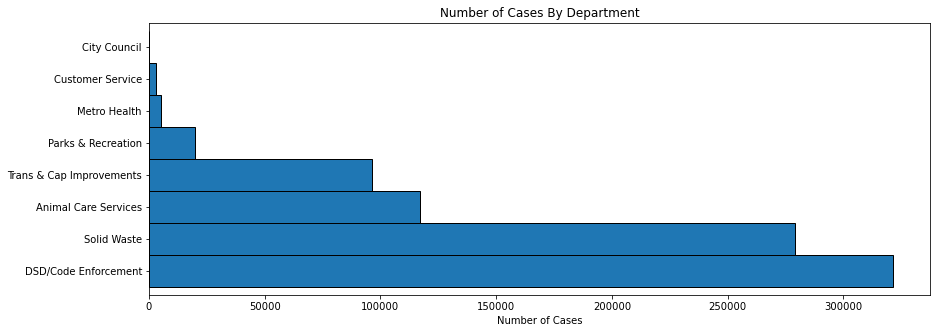

In [11]:
# First aggregate with spark
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

Text(0.5, 1.0, 'Case Lifetime By Department')

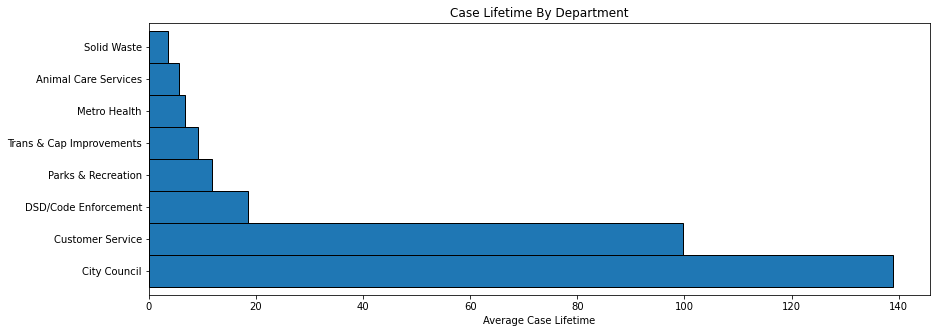

In [15]:
# first aggregate with spark
(
    df.groupBy("department")
    .agg(mean("case_lifetime").alias("avg_case_lifetime"))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("department")
    .avg_case_lifetime.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.xlabel("Average Case Lifetime")
plt.ylabel("")
plt.title("Case Lifetime By Department")

Average case lifetime by department for both open and closed cases:

In [16]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=15)

In [20]:
(
    df.groupBy("department")
    .agg(round(mean("case_lifetime"), 2))).show()

+--------------------+----------------------------+
|          department|round(avg(case_lifetime), 2)|
+--------------------+----------------------------+
|         Solid Waste|                        3.48|
|Animal Care Services|                        5.57|
|Trans & Cap Impro...|                        9.08|
|  Parks & Recreation|                       11.74|
|    Customer Service|                       99.65|
|        Metro Health|                        6.79|
|        City Council|                      138.94|
|DSD/Code Enforcement|                       18.51|
+--------------------+----------------------------+



In [19]:
(
    df.groupBy("department")
    .pivot("case_status")
    .agg(round(mean("case_lifetime"), 2))).show()

+--------------------+------+------+
|          department|Closed|  Open|
+--------------------+------+------+
|         Solid Waste|   3.4| 16.45|
|Animal Care Services|  5.51| 21.36|
|Trans & Cap Impro...|   8.0| 54.39|
|    Customer Service| 48.94|172.94|
|  Parks & Recreation| 10.66| 64.72|
|        Metro Health|  6.82|  4.64|
|        City Council| 29.25|154.07|
|DSD/Code Enforcement| 15.64| 91.56|
+--------------------+------+------+



Text(0.5, 0, 'Average case lifetime')

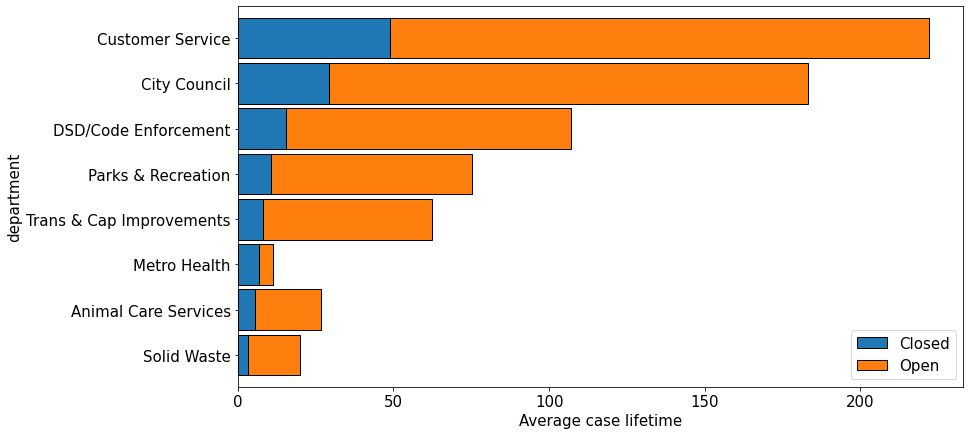

In [23]:
(
    df.groupBy("department")
    .pivot("case_status")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("Closed")
    .toPandas()
    .set_index('department')
    .plot.barh(ec='black', width=.9, stacked = True)
)
plt.xlabel('Average case lifetime')

Text(0.5, 0, 'Average case lifetime')

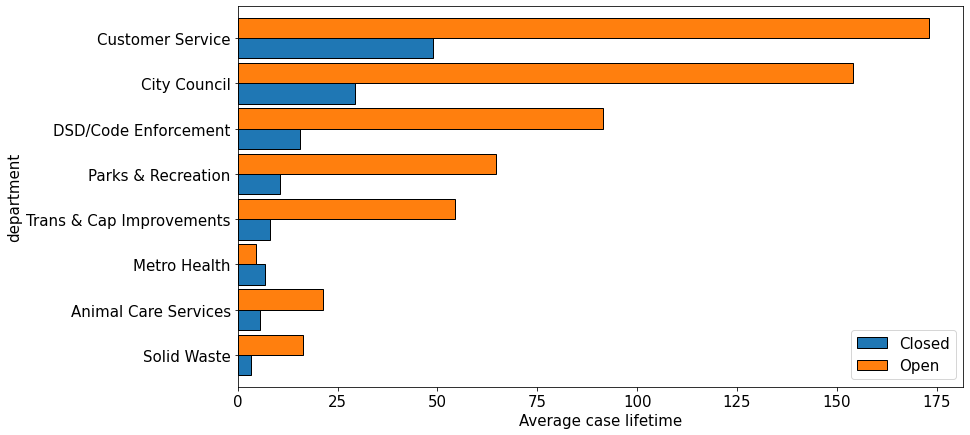

In [24]:
(
    df.groupBy("department")
    .pivot("case_status")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("Closed")
    .toPandas()
    .set_index('department')
    .plot.barh(ec='black', width=.9)
)
plt.xlabel('Average case lifetime')

## Sample

In [25]:
sample = df.sample(fraction=0.01, seed=13).toPandas()
print("shape:", sample.shape)
sample.head()

shape: (8524, 20)


,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127339,2018-01-01 06:58:00,2018-01-02 15:32:00,2018-01-17 08:30:00,False,-14.706620,True,Front Or Side Yard Parking,16.063796,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.100946,78251,219,1.0,1,DSD/Code Enforcement,True
1,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True
2,1014127446,2018-01-01 11:27:00,2018-01-03 17:08:00,2018-01-06 11:27:00,False,-2.763333,True,Aggressive Animal(Non-Critical),5.000000,Closed,139344,SAN FERNANDO and SAN HORACIO S,005,-0.394762,,219,2.0,2,Animal Care Services,True
3,1014127470,2018-01-01 12:33:00,2018-01-01 12:43:00,2020-09-26 12:33:00,False,-998.993079,True,Stray Animal,999.000000,Closed,139344,"159 SURFRIDER, San Antonio, 78242",004,-142.713297,78242,219,0.0,0,Animal Care Services,True
4,1014127599,2018-01-01 15:25:00,2018-01-03 05:52:00,2018-01-02 03:25:00,True,1.101817,True,Trapped/Confined Animal,0.500000,Closed,rs16746,"633 ST MARYS S, San Antonio, 78205",001,0.157402,78205,219,2.0,2,Animal Care Services,True


<AxesSubplot:ylabel='Frequency'>

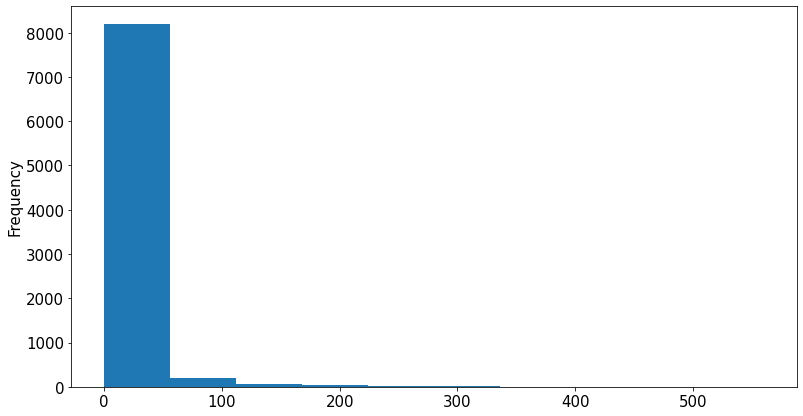

In [26]:
sample.case_lifetime.plot.hist()

In [27]:
pd.cut(sample.case_lifetime, 4).value_counts().sort_index()

(-0.56, 140.0]    8436
(140.0, 280.0]      69
(280.0, 420.0]      14
(420.0, 560.0]       5
Name: case_lifetime, dtype: int64

In [28]:
pd.qcut(sample.case_lifetime, 5, duplicates='drop').value_counts().sort_index()

(-0.001, 1.0]    4189
(1.0, 3.0]       1132
(3.0, 12.0]      1539
(12.0, 560.0]    1664
Name: case_lifetime, dtype: int64

[0, 1)        2501
[1, 2)        1688
[2, 5)        1478
[5, 15)       1401
[15, 1000)    1456
Name: case_lifetime, dtype: int64


Text(0, 0.5, '# of Cases')

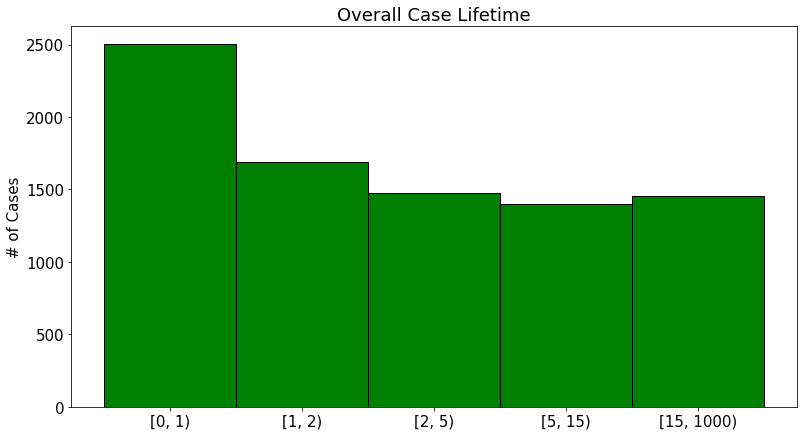

In [31]:
# In the call to `pd.cut`, we add right=False so that the behavior of pd.cut
# aligns with the behavior of np.histogram, which is what matplotlib uses when
# constructing a histogram.

# custom bins of varying widths
bins = [0, 1, 2, 5, 15, 1000]

print(
    pd.cut(sample.case_lifetime, bins, right=False).value_counts().sort_index()
)

pd.cut(
    sample.case_lifetime, bins, right=False
).value_counts().sort_index().plot.bar(
    width=1, edgecolor="black", color="green"
)
plt.xticks(rotation=0)
plt.title("Overall Case Lifetime")
plt.ylabel('# of Cases')

In [32]:
closed_cases = sample.query("case_closed")
open_cases = sample.query("not case_closed")

Text(0.5, 0.98, 'Distribution of Case Lifetime')

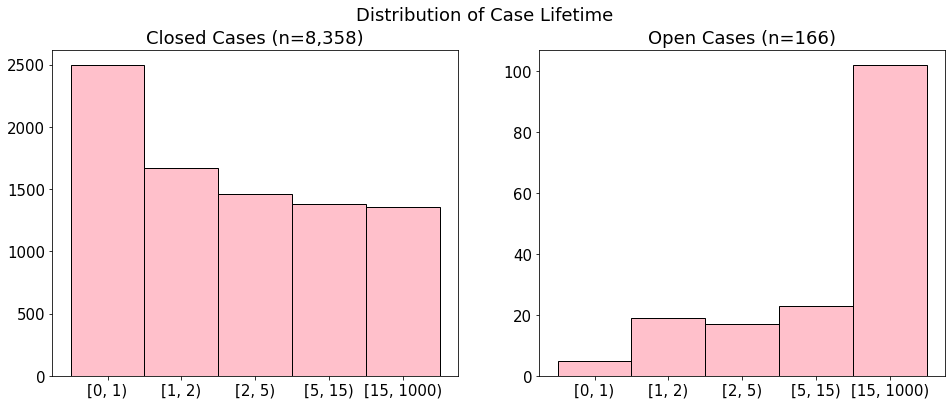

In [33]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
(
    pd.cut(closed_cases.case_lifetime, bins=bins, right=False)
    .value_counts()
    .sort_index()
    .plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)
plt.title("Closed Cases (n={:,})".format(closed_cases.shape[0]))
plt.xticks(rotation=0)

plt.subplot(122)
(
    pd.cut(open_cases.case_lifetime, bins=bins, right=False)
    .value_counts()
    .sort_index()
    .plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)
plt.title("Open Cases (n={:,})".format(open_cases.shape[0]))
plt.xticks(rotation=0)

plt.suptitle("Distribution of Case Lifetime")

In [36]:
# (
#     sample.assign(closed_within_a_day=sample.case_lifetime <= 1)
#     .groupby('closed_within_a_day')
#     .size()
#     .plot.barh(ec='black', fc='firebrick', width=.9)
# )
# plt.gca().set(
#     title='Most Cases are Closed Within a day or 2',
#     yticklabels=['Longer than 1 Day', 'Closed within a day'],
#     ylabel='',
#     xlabel='# of Cases'
# )

## Aggregating

In [35]:
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

cases_by_day.show(5, truncate=False)

+------------------------+----------------+----------------+
|department              |case_opened_date|case_closed_date|
+------------------------+----------------+----------------+
|Animal Care Services    |2018-01-01      |2018-01-01      |
|Trans & Cap Improvements|2018-01-01      |2018-01-03      |
|Trans & Cap Improvements|2018-01-01      |2018-01-02      |
|DSD/Code Enforcement    |2018-01-01      |2018-01-02      |
|Animal Care Services    |2018-01-01      |2018-01-01      |
+------------------------+----------------+----------------+
only showing top 5 rows



In [37]:
(
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas())

,case_opened_date,count
0,2017-01-01,155
1,2017-01-02,1397
2,2017-01-03,1760
3,2017-01-04,1613
4,2017-01-05,1791
...,...,...
580,2018-08-04,665
581,2018-08-05,319
582,2018-08-06,2071
583,2018-08-07,2405


In [38]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'
cases_opened_by_day

case_opened_date
2017-01-01     155
2017-01-02    1397
2017-01-03    1760
2017-01-04    1613
2017-01-05    1791
              ... 
2018-08-04     665
2018-08-05     319
2018-08-06    2071
2018-08-07    2405
2018-08-08     604
Name: cases_opened, Length: 585, dtype: int64

In [39]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [40]:
cases_closed_by_day

case_closed_date
2017-01-01      67
2017-01-02     385
2017-01-03     734
2017-01-04    1206
2017-01-05    1173
              ... 
2018-08-04     730
2018-08-05     197
2018-08-06    1713
2018-08-07    2096
2018-08-08     680
Name: cases_closed, Length: 585, dtype: int64

In [41]:
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
ts

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173
...,...,...
2018-08-04,665,730
2018-08-05,319,197
2018-08-06,2071,1713
2018-08-07,2405,2096


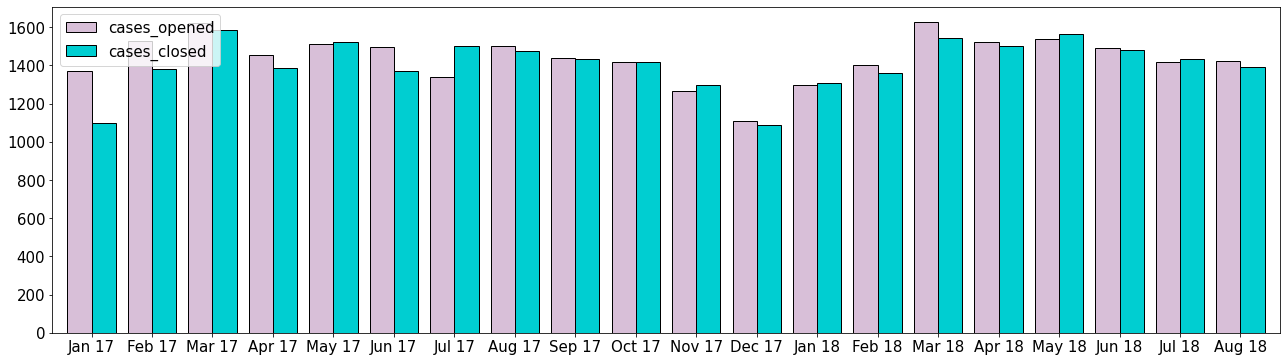

In [42]:
ts.resample("M").mean().plot.bar(
    figsize=(22, 6), width=0.8, ec="black", color=["thistle", "darkturquoise"]
)

# pretty x-axis labels
ticks, labels = plt.xticks()
labels = pd.to_datetime([l.get_text() for l in labels]).strftime("%b %y")
plt.xticks(ticks, labels, rotation=0)
None

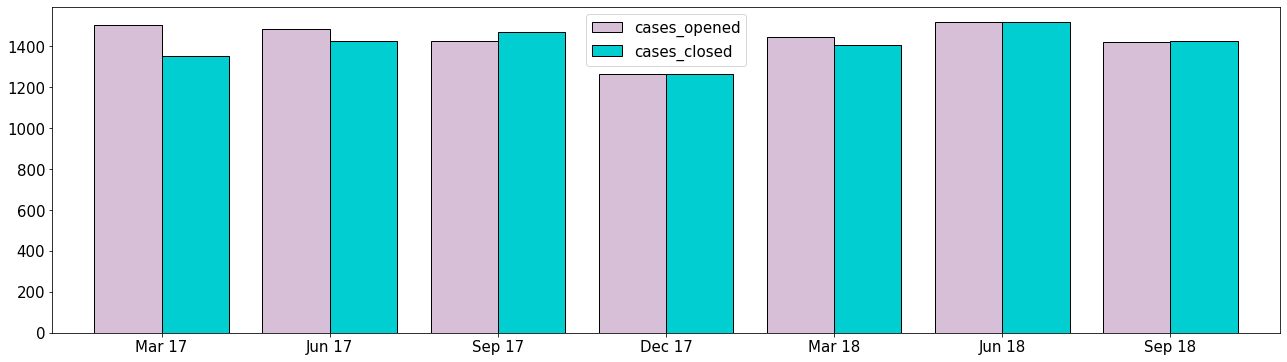

In [48]:
ts.resample("Q").mean().plot.bar(
    figsize=(22, 6), width=0.8, ec="black", color=["thistle", "darkturquoise"]
)

# pretty x-axis labels
ticks, labels = plt.xticks()
labels = pd.to_datetime([l.get_text() for l in labels]).strftime("%b %y")
plt.xticks(ticks, labels, rotation=0)
None

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '0-Sun'),
  Text(1, 0, '1-Mon'),
  Text(2, 0, '2-Tue'),
  Text(3, 0, '3-Wed'),
  Text(4, 0, '4-Thu'),
  Text(5, 0, '5-Fri'),
  Text(6, 0, '6-Sat')])

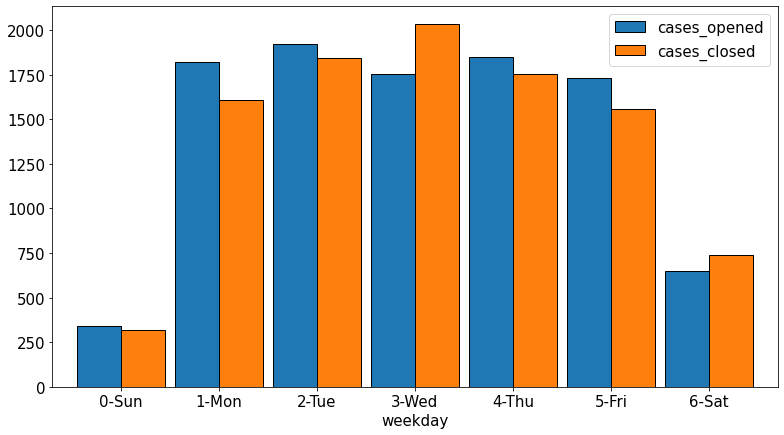

In [43]:
ts['weekday'] = ts.index.strftime('%w-%a')
ts.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)
plt.xticks(rotation=0)